In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data

## Read survey and epc data

In [2]:
# Read 'SensorID_EPC_Survey_Open_Data' file
file_path_ID ='Data/SensorID_EPC_Survey_Open_Data.csv'
df_ID_time = pd.read_csv(file_path_ID)

In [3]:
ID_list=df_ID_time['ID']

In [4]:
# Convert field to datetime type 
df_ID_time['Battery Charging Start Time'] = pd.to_datetime(df_ID_time['Battery Charging Start Time'], format="%d/%m/%Y %H:%M")  
df_ID_time['Battery Charging End Time'] = pd.to_datetime(df_ID_time['Battery Charging End Time'], format="%d/%m/%Y %H:%M")  

df_ID_time['Recording Start Time (Participant)'] = pd.to_datetime(df_ID_time['Recording Start Time (Participant) '], format="%d/%m/%Y %H:%M")  
df_ID_time['Recording End Time (Participant)'] = pd.to_datetime(df_ID_time['Recording End Time (Participant) '], format="%d/%m/%Y %H:%M")  

## Generate statistics dataframe

In [5]:
description_dfs = []


# Iterate over each sensor
for sensor_id in ID_list:
    try:
        df = pd.read_csv('Data/Household Indoor Sensor Measurement Data/'+sensor_id+'.csv')

        # Convert field to datetime type
        df['TIME'] = pd.to_datetime(df['TIME'])
        df['TIME'] = df['TIME']

        selected_sensor = df_ID_time[df_ID_time['ID'] == sensor_id]
            
        if pd.notnull(selected_sensor['Battery Charging Start Time']).any():
            start_date = selected_sensor['Battery Charging Start Time'] + pd.Timedelta(hours=1)
            # Delay 1 hour to allow the sensor settled in the indoor condition and improve the accuracy of indoor temperature measurements
            end_date = selected_sensor['Battery Charging End Time']
        else:
            start_date = selected_sensor['Recording Start Time (Participant) ']
            end_date = selected_sensor['Recording End Time (Participant) '] 
            
        start_date_value = start_date.iloc[0]
        end_date_value = end_date.iloc[0]

        sliced_df = df[(df['TIME'] >= start_date_value) & (df['TIME'] <= end_date_value)]

        # Extract the date, time, and hour from the timestamp
        sliced_df['Date'] = sliced_df['TIME'].dt.date
        sliced_df['Time'] = sliced_df['TIME'].dt.time
        sliced_df['Hour'] = sliced_df['TIME'].dt.hour
        

        # Temperature statistics
        description = sliced_df['TEMP'].describe()
        description_df = pd.DataFrame(description)
        description_df = description_df.T
        description_df.reset_index(drop=True, inplace=True)
        description_df['ID'] = sensor_id
        
        # Add heat period days in DataFrame
        # Calculate rolling mean over a 3-day window
        rolling_mean = sliced_df['TEMP'].rolling(1440, center=True).mean()
        # Define a threshold temperature for identifying heat periods
        threshold_temp = 25
        # Create a mask to identify heat periods where rolling mean is greater than threshold_temp
        heat_period_mask = rolling_mean > threshold_temp

        heat_periods = []
        current_period = None
        total_heat_period_duration = 0  

        for i, is_heat_period in enumerate(heat_period_mask):
            if is_heat_period:
                if current_period is None:
                    current_period = [i]
                else:
                    current_period.append(i)
            elif current_period is not None:
                if len(current_period) > 4380:  # Check if it's more than 3 days
                    start_date = df['TIME'].iloc[current_period[0]].strftime('%Y-%m-%d')
                    end_date = df['TIME'].iloc[current_period[-1]].strftime('%Y-%m-%d')
                    start_date_timestamp = pd.to_datetime(start_date)
                    end_date_timestamp = pd.to_datetime(end_date)
                    period_duration = (end_date_timestamp - start_date_timestamp).days
                    total_heat_period_duration += period_duration  # Accumulate the duration

                current_period = None

        description_df['heat_period'] = total_heat_period_duration
        
        # Add monitoring days for each sensor in DataFrame
        periods = sliced_df['Date'].iloc[-1] - sliced_df['Date'].iloc[0]
        periods = periods.days
        description_df['recored_periods'] = periods 

        # Append the description DataFrame to the list
        description_dfs.append(description_df)
        
    except Exception as e:
        print(f"Error in {str(e)}")

# Concatenate the description DataFrames for all sensors into a single DataFrame
description_df = pd.concat(description_dfs, ignore_index=True)


print(description_df)


C:\Users\ch335s\AppData\Local\Temp\ipykernel_17896\4207018955.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['Date'] = sliced_df['TIME'].dt.date
C:\Users\ch335s\AppData\Local\Temp\ipykernel_17896\4207018955.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['Time'] = sliced_df['TIME'].dt.time
C:\Users\ch335s\AppData\Local\Temp\ipykernel_17896\4207018955.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

      count       mean       std    min     25%    50%    75%    max  \
0   54906.0  24.414297  2.019142  20.52  23.050  23.97  25.39  30.25   
1   70281.0  25.562214  1.266366  20.54  24.760  25.46  26.32  29.19   
2   56718.0  23.537636  1.763632  20.00  22.160  23.37  24.70  30.70   
3   56919.0  25.728024  1.696041  22.02  24.270  25.77  26.90  30.40   
4   64961.0  25.067441  1.384199  18.98  24.260  25.23  25.83  28.86   
5    1905.0  22.838919  0.794798  21.45  22.160  22.95  23.49  24.27   
6   67838.0  22.689428  1.106300  20.57  21.960  22.53  23.38  25.96   
7   52662.0  23.812827  2.498582  18.27  21.550  23.90  25.56  31.76   
8   55489.0  23.142175  1.767700  18.30  21.840  23.12  24.18  28.12   
9   69039.0  23.306204  2.355669  18.47  21.460  23.10  24.81  31.45   
10  64624.0  24.214287  1.262814  19.94  23.490  24.32  24.98  27.27   
11  50095.0  24.828931  1.462743  21.89  23.510  24.94  25.82  28.07   
12  52417.0  23.534161  2.378468  19.20  21.700  23.45  24.77  2

C:\Users\ch335s\AppData\Local\Temp\ipykernel_17896\4207018955.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['Date'] = sliced_df['TIME'].dt.date
C:\Users\ch335s\AppData\Local\Temp\ipykernel_17896\4207018955.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['Time'] = sliced_df['TIME'].dt.time
C:\Users\ch335s\AppData\Local\Temp\ipykernel_17896\4207018955.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [6]:
file_path_ID ='Data/SensorID_EPC_Survey_Open_Data.csv'
df = pd.read_csv(file_path_ID)

## Merge two DataFrame

In [7]:
df = df.merge(description_df, on='ID', suffixes=('_left', '_right'))

In [8]:
# Calculate the sustained heat period proportion of whole monitoring days
df['perc_heat']=round(df['heat_period']/df['recored_periods']*100,2)

# Two-sampled t-test

## EPC

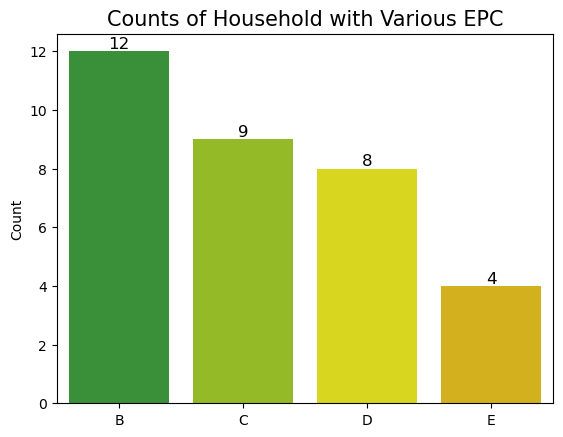

In [9]:
# Plot the distribution of EPC
counts = df['Current EPC Rating '].value_counts()

category_order=["B","C","D",'E']
colors =["#2C9F29", "#A0D20E", "#F8F400", "#F1C300"]
plt.figure()
sns.barplot(x=counts.index, y=counts.values, order=category_order, palette=colors)


for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12, color='black')


plt.xlabel('')
plt.ylabel('Count')
plt.title('Counts of Household with Various EPC', fontsize=15)

plt.show()

### Maximum temperature

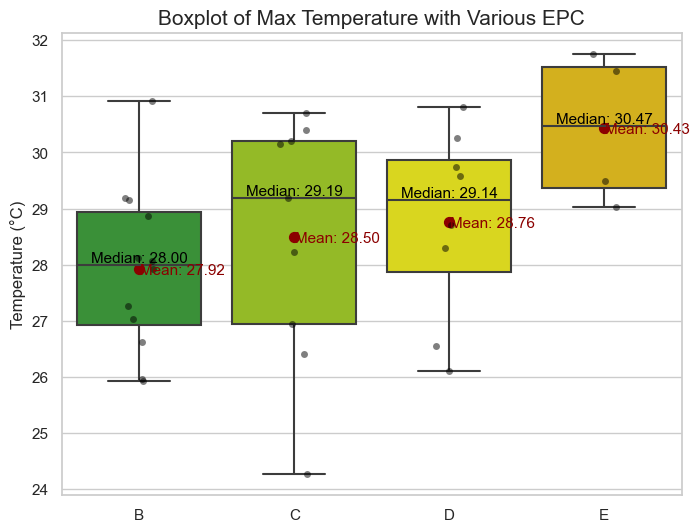

In [10]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
category_order=["B","C","D",'E']
ax = sns.boxplot(x='Current EPC Rating ', y='max', data=df, palette=colors, order=category_order)
sns.stripplot(x='Current EPC Rating ', y='max', data=df, jitter=True, order=category_order, color='black', alpha=0.5)

# Calculate the median and mean
medians = df.groupby('Current EPC Rating ')['max'].median()
means = df.groupby('Current EPC Rating ')['max'].mean()

mean_points = [means[category] for category in category_order]
plt.scatter(ax.get_xticks(), mean_points, marker='o', color='darkred', s=50, label='Mean')
# Annotate the median and mean
for xtick in ax.get_xticks():
    ax.text(xtick, medians[category_order[xtick]]+0.05, f'Median: {medians[category_order[xtick]]:.2f}', horizontalalignment='center', color='black', fontsize=11)
    ax.text(xtick+0.28, means[category_order[xtick]]-0.1, f'Mean: {means[category_order[xtick]]:.2f}', horizontalalignment='center', color='darkred', fontsize=11)

plt.xlabel('')
plt.ylabel('Temperature (°C)')
plt.title('Boxplot of Max Temperature with Various EPC', fontsize=15)
plt.show()

### T-test for maximum temperature

In [11]:
B=df[df['Current EPC Rating ']=='B']['max']
C=df[df['Current EPC Rating ']=="C"]['max']
D=df[df['Current EPC Rating ']=="D"]['max']
E=df[df['Current EPC Rating ']=="E"]['max']

In [12]:
import scipy.stats as stats

# ANOVA
f_statistic, p_value = stats.f_oneway(B,C,D,E)

In [13]:
p_value

0.12276839591763096

In [14]:
f_statistic

2.0938591511106885

In [15]:
t_statistic, p_value = stats.ttest_ind(B, C)
p_value

0.4782363671838442

In [16]:
t_statistic, p_value = stats.ttest_ind(B, D)
p_value

0.2556483474913897

In [17]:
t_statistic, p_value = stats.ttest_ind(B, E)
p_value

0.009490695445608559

In [18]:
t_statistic, p_value = stats.ttest_ind(C, D)
p_value

0.794714920161521

In [19]:
t_statistic, p_value = stats.ttest_ind(C, E)
p_value

0.14020326697481958

In [20]:
t_statistic, p_value = stats.ttest_ind(D, E)
p_value

0.11985489324277886

### Minimum temperature

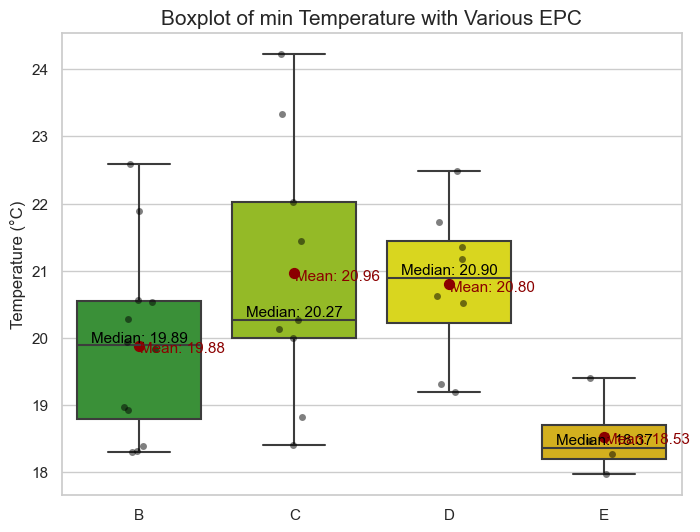

In [21]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
category_order=["B","C","D",'E']
ax = sns.boxplot(x='Current EPC Rating ', y='min', data=df, palette=colors, order=category_order)
sns.stripplot(x='Current EPC Rating ', y='min', data=df, jitter=True, order=category_order, color='black', alpha=0.5)

# Calculate the median and mean
medians = df.groupby('Current EPC Rating ')['min'].median()
means = df.groupby('Current EPC Rating ')['min'].mean()

mean_points = [means[category] for category in category_order]
plt.scatter(ax.get_xticks(), mean_points, marker='o', color='darkred', s=50, label='Mean')
# Annotate the median and mean
for xtick in ax.get_xticks():
    ax.text(xtick, medians[category_order[xtick]]+0.05, f'Median: {medians[category_order[xtick]]:.2f}', horizontalalignment='center', color='black', fontsize=11)
    ax.text(xtick+0.28, means[category_order[xtick]]-0.1, f'Mean: {means[category_order[xtick]]:.2f}', horizontalalignment='center', color='darkred', fontsize=11)

plt.xlabel('')
plt.ylabel('Temperature (°C)')
plt.title('Boxplot of min Temperature with Various EPC', fontsize=15)
plt.show()

### T-test for minimum temperature

In [22]:
B=df[df['Current EPC Rating ']=='B']['min']
C=df[df['Current EPC Rating ']=="C"]['min']
D=df[df['Current EPC Rating ']=="D"]['min']
E=df[df['Current EPC Rating ']=="E"]['min']

In [23]:
import scipy.stats as stats

# ANOVA
f_statistic, p_value = stats.f_oneway(B,C,D,E)

In [24]:
p_value

0.0391350763144506

In [25]:
f_statistic

3.1691950466817467

In [26]:
t_statistic, p_value = stats.ttest_ind(B, C)
p_value

0.1552248793813648

In [27]:
t_statistic, p_value = stats.ttest_ind(B, D)
p_value

0.1393861944581774

In [28]:
t_statistic, p_value = stats.ttest_ind(B, E)
p_value

0.08555721879222279

In [29]:
t_statistic, p_value = stats.ttest_ind(C, D)
p_value

0.8370578964036777

In [30]:
t_statistic, p_value = stats.ttest_ind(C, E)
p_value

0.036931296113387

In [31]:
t_statistic, p_value = stats.ttest_ind(D, E)
p_value

0.004262694787445767

There is a statistically significant difference between EPC C/D houses and EPC E house at about 2.5 Celsius degree. 

## Communal heating system

_**Note that the rest of the code cannot run directly because the data for 'if you are communal heating system' is not available at the moment.**_

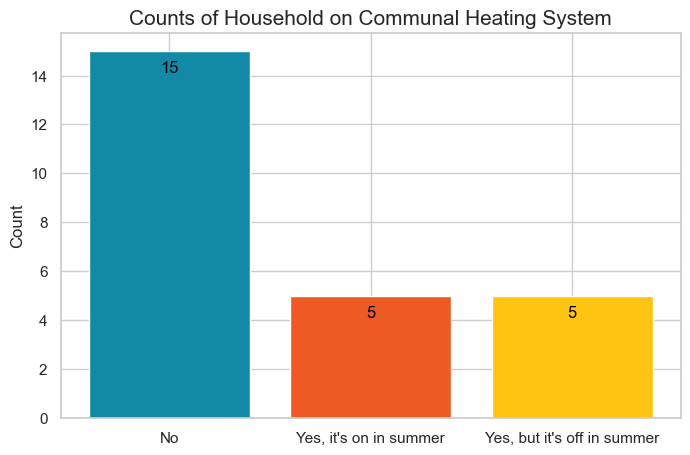

In [61]:
plt.figure(figsize=(8,5))

counts = df['if_communal'].value_counts()
colors = ['#1289A7', '#EE5A24','#FFC312']

plt.bar(counts.index, counts.values,color=colors)

for i, count in enumerate(counts.values):
    plt.text(i, count-1, str(count), ha='center', va='bottom', fontsize=12, color='black')

plt.xlabel('')
plt.ylabel('Count')
plt.title('Counts of Household on Communal Heating System', fontsize=15)

plt.show()

### Mean temperature

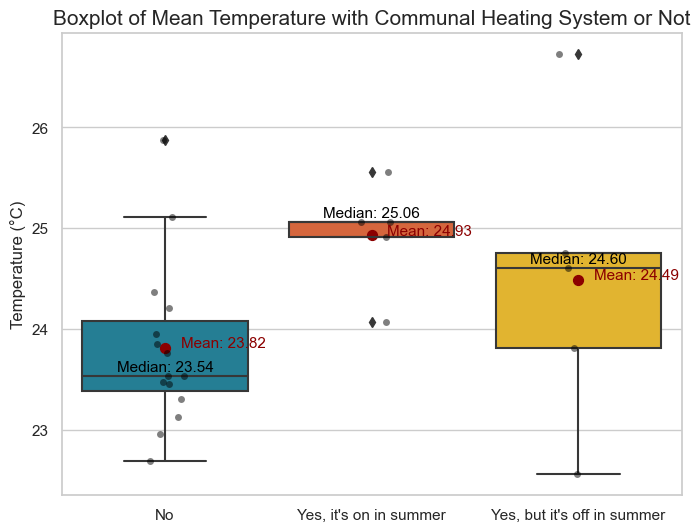

In [63]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

colors = ['#1289A7', '#EE5A24','#FFC312']

ax = sns.boxplot(x='if_communal', y='mean', data=df_survey, palette=colors, order=category_order)
sns.stripplot(x='if_communal', y='mean', data=df_survey, jitter=True, order=category_order, color='black', alpha=0.5)

medians = df.groupby('if_communal')['mean'].median()
means = df.groupby('if_communal')['mean'].mean()

mean_points = [means[category] for category in category_order]
plt.scatter(ax.get_xticks(), mean_points, marker='o', color='darkred', s=50, label='Mean')

for xtick in ax.get_xticks():
    ax.text(xtick, medians[category_order[xtick]]+0.05, f'Median: {medians[category_order[xtick]]:.2f}', horizontalalignment='center', color='black', fontsize=11)
    ax.text(xtick+0.28, means[category_order[xtick]], f'Mean: {means[category_order[xtick]]:.2f}', horizontalalignment='center', color='darkred', fontsize=11)

plt.xlabel('')
plt.ylabel('Temperature (°C)')
plt.title('Boxplot of Mean Temperature with Communal Heating System or Not', fontsize=15)

plt.show()

### T-test for mean temperature

In [67]:
import scipy.stats as stats

# ANOVA
f_statistic, p_value = stats.f_oneway(communal_no, communal_yes_off,communal_yes_on)

In [68]:
p_value

0.07443489671607653

In [69]:
f_statistic

2.930235216746733

In [75]:
t_statistic, p_value = stats.ttest_ind(communal_no, communal_yes_off)
p_value

0.2158274945716955

In [76]:
t_statistic, p_value = stats.ttest_ind(communal_no, communal_yes_on)
p_value

0.011658834158933998

In [77]:
t_statistic, p_value = stats.ttest_ind(communal_yes_on, communal_yes_off)
p_value

0.5583323292287945

A statistically significant mean temperature difference at 1.1 Celsius degrees between households without communal heating system and households that cannot turn the communal heating off. 

### Heat periods proportion

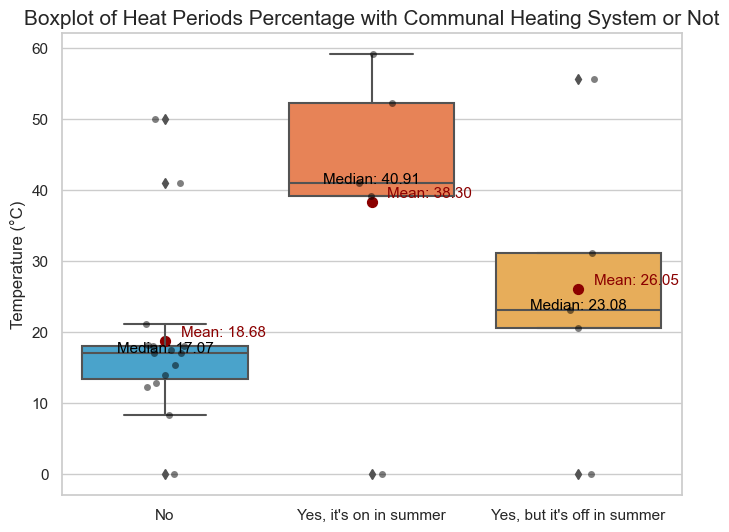

In [118]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
colors = ['#34ace0', '#ff793f','#ffb142']
category_order=["No","Yes, it's on in summer","Yes, but it's off in summer"]
ax = sns.boxplot(x='if_communal', y='perc_heat', data=df, palette=colors, order=category_order)
sns.stripplot(x='if_communal', y='perc_heat', data=df, jitter=True, order=category_order, color='black', alpha=0.5)


medians = df.groupby('if_communal')['perc_heat'].median()
means = df.groupby('if_communal')['perc_heat'].mean()

mean_points = [means[category] for category in category_order]
plt.scatter(ax.get_xticks(), mean_points, marker='o', color='darkred', s=50, label='perc_heat')

for xtick in ax.get_xticks():
    ax.text(xtick, medians[category_order[xtick]]+0.05, f'Median: {medians[category_order[xtick]]:.2f}', horizontalalignment='center', color='black', fontsize=11)
    ax.text(xtick+0.28, means[category_order[xtick]]+0.6, f'Mean: {means[category_order[xtick]]:.2f}', horizontalalignment='center', color='darkred', fontsize=11)

plt.xlabel('')
plt.ylabel('Temperature (°C)')
plt.title('Boxplot of Heat Periods Percentage with Communal Heating System or Not', fontsize=15)
plt.show()

### T-test for heat periods proportion

In [119]:
communal_no=df_survey[df_survey['if_communal']=='No']['perc_heat']
communal_yes_off=df_survey[df_survey['if_communal']=="Yes, but it's off in summer"]['perc_heat']
communal_yes_on=df_survey[df_survey['if_communal']=="Yes, it's on in summer"]['perc_heat']

In [121]:
import scipy.stats as stats

# ANOVA
f_statistic, p_value = stats.f_oneway(communal_no, communal_yes_off,communal_yes_on)

In [122]:
p_value

0.08291145230420803

In [123]:
f_statistic

2.794325060762251

In [129]:
t_statistic, p_value = stats.ttest_ind(communal_no, communal_yes_off)
p_value

0.3308736810532007

In [130]:
t_statistic, p_value = stats.ttest_ind(communal_no, communal_yes_on)
p_value

0.022382294711848487

In [131]:
t_statistic, p_value = stats.ttest_ind(communal_yes_on, communal_yes_off)
p_value

0.3954524734808068

A statistically significant sustained heat periods proportion difference between households without communal heating system and households that cannot turn the communal heating off.